In [1]:
# Install medmnist library
!pip install medmnist

# Import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import medmnist
from medmnist import INFO, Evaluator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")
print(f"MedMNIST Version: {medmnist.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 4.0 MB/s eta 0:00:00
TensorFlow Version: 2.19.0
MedMNIST Version: 3.0.2


In [2]:
# Get dataset information
data_flag = 'bloodmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

print(f"Dataset: {data_flag}")
print(f"Task: {task}")
print(f"Number of channels: {n_channels}")
print(f"Number of classes: {n_classes}")
print(f"\nClass labels: {info['label']}")

# Load the datasets
train_dataset = DataClass(split='train', download=download)
val_dataset = DataClass(split='val', download=download)
test_dataset = DataClass(split='test', download=download)

print(f"\nTraining samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Dataset: bloodmnist
Task: multi-class
Number of channels: 3
Number of classes: 8

Class labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}


100%|██████████| 35.5M/35.5M [00:31<00:00, 1.12MB/s]



Training samples: 11959
Validation samples: 1712
Test samples: 3421


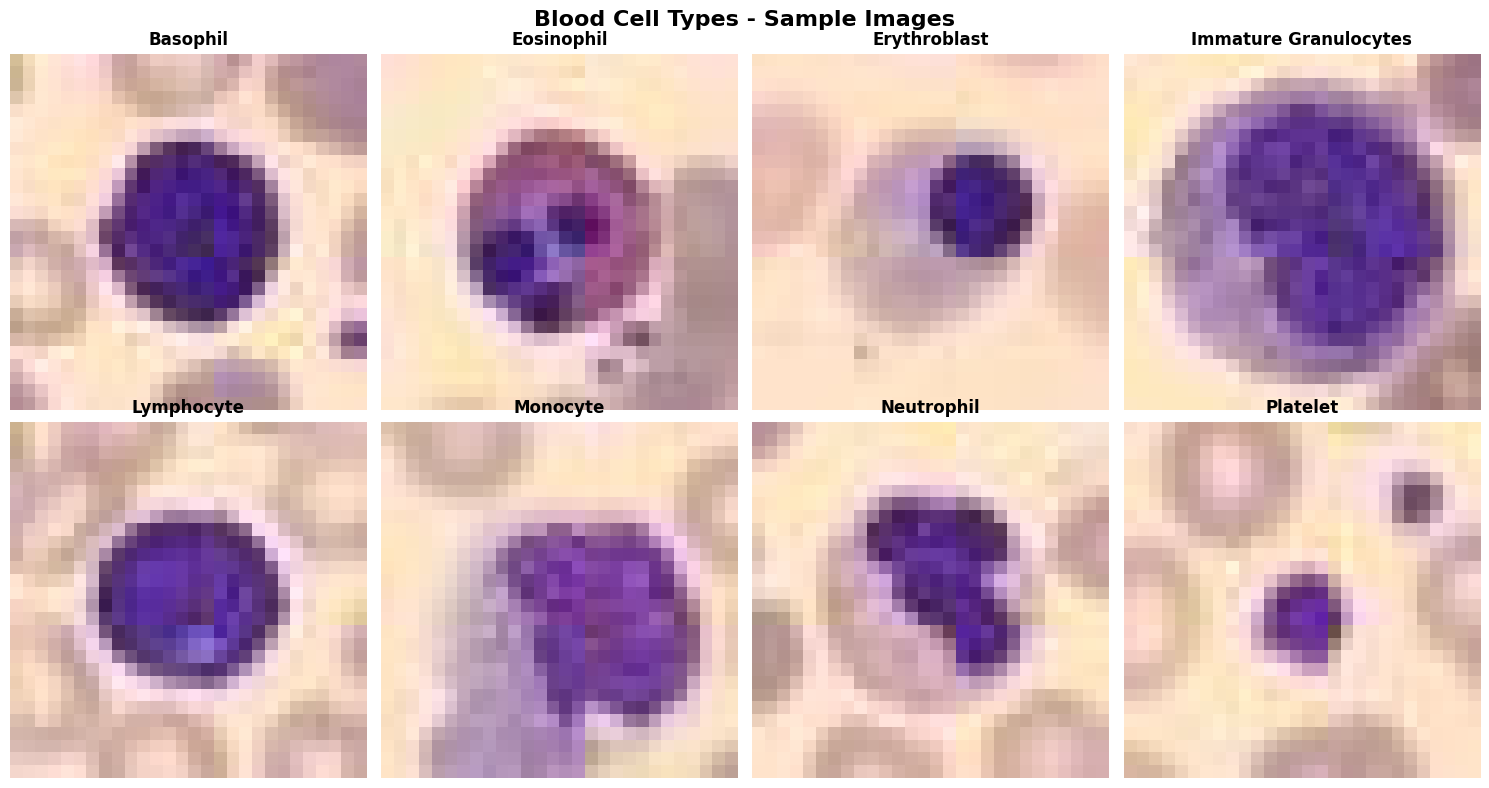

In [3]:
# Define class names
class_names = ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature Granulocytes',
               'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']

# Visualize samples from each class
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Blood Cell Types - Sample Images', fontsize=16, fontweight='bold')

for i in range(8):
    for idx in range(len(train_dataset)):
        img, label = train_dataset[idx]
        if label[0] == i:
            ax = axes[i // 4, i % 4]
            ax.imshow(img)
            ax.set_title(f'{class_names[i]}', fontweight='bold')
            ax.axis('off')
            break

plt.tight_layout()
plt.show()

In [5]:
# Extract images and labels
x_train = train_dataset.imgs
y_train = train_dataset.labels.squeeze()

x_val = val_dataset.imgs
y_val = val_dataset.labels.squeeze()

x_test = test_dataset.imgs
y_test = test_dataset.labels.squeeze()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation data shape: {x_val.shape}")
print(f"Test data shape: {x_test.shape}")
print("\nData preprocessing complete! ✓")

Training data shape: (11959, 28, 28, 3)
Training labels shape: (11959,)
Validation data shape: (1712, 28, 28, 3)
Test data shape: (3421, 28, 28, 3)

Data preprocessing complete! ✓


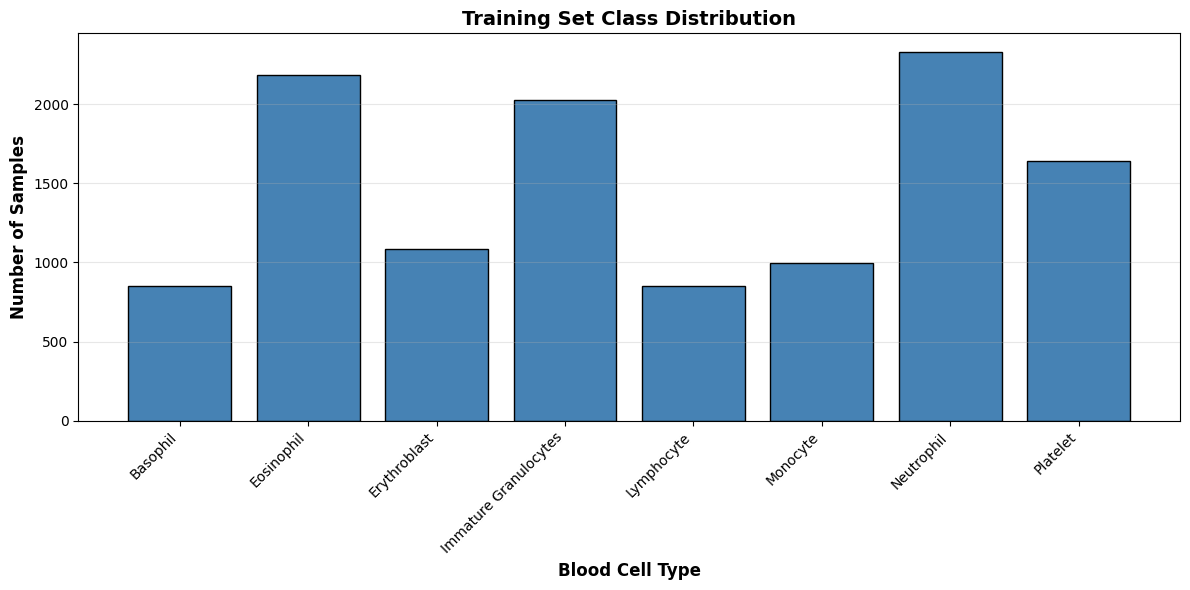


Class distribution:
Basophil: 852 samples
Eosinophil: 2181 samples
Erythroblast: 1085 samples
Immature Granulocytes: 2026 samples
Lymphocyte: 849 samples
Monocyte: 993 samples
Neutrophil: 2330 samples
Platelet: 1643 samples


In [6]:
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

plt.figure(figsize=(12, 6))
plt.bar([class_names[i] for i in unique], counts, color='steelblue', edgecolor='black')
plt.xlabel('Blood Cell Type', fontsize=12, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
plt.title('Training Set Class Distribution', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nClass distribution:")
for i, count in class_distribution.items():
    print(f"{class_names[i]}: {count} samples")

In [7]:
# Data augmentation for training
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

datagen.fit(x_train)
print("Data augmentation configured successfully! ✓")
print("\nAugmentation techniques applied:")
print("  • Random rotation (±20 degrees)")
print("  • Random shifts (10%)")
print("  • Random flips (horizontal & vertical)")
print("  • Random zoom (±10%)")

Data augmentation configured successfully! ✓

Augmentation techniques applied:
  • Random rotation (±20 degrees)
  • Random shifts (10%)
  • Random flips (horizontal & vertical)
  • Random zoom (±10%)


In [8]:
def create_cnn_model(input_shape=(28, 28, 3), num_classes=8):
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create and compile model
model = create_cnn_model()
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 619,432 (2.36 MB)

 Trainable params: 617,768 (2.36 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [9]:
# Callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_blood_cell_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]
print("Training callbacks configured! ✓")
print("\n• Early Stopping: Stops if no improvement for 10 epochs")
print("• Learning Rate Reduction: Reduces LR if plateauing")
print("• Model Checkpoint: Saves best model automatically")

Training callbacks configured! ✓

• Early Stopping: Stops if no improvement for 10 epochs
• Learning Rate Reduction: Reduces LR if plateauing
• Model Checkpoint: Saves best model automatically


In [10]:
# Train the model
BATCH_SIZE = 64
EPOCHS = 50

print("Starting training... This will take 15-25 minutes.")
print("You'll see progress bars for each epoch.\n")

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*60)
print("TRAINING COMPLETE! 🎉")
print("="*60)

Starting training... This will take 15-25 minutes.
You'll see progress bars for each epoch.

Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4177 - loss: 1.8392
Epoch 1: val_accuracy improved from -inf to 0.14720, saving model to best_blood_cell_model.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - accuracy: 0.4185 - loss: 1.8362 - val_accuracy: 0.1472 - val_loss: 4.2650 - learning_rate: 0.0010
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7496 - loss: 0.6791
Epoch 2: val_accuracy improved from 0.14720 to 0.22664, saving model to best_blood_cell_model.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.7497 - loss: 0.6789 - val_accuracy: 0.2266 - val_loss: 4.5615 - learning_rate: 0.0010
Epoch 3/50
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7917 - loss: 0.5549
Epoch 3: val_accuracy improved from 0.22664 to 0.66822, saving model to best_blood_cell_model.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.7918 - l

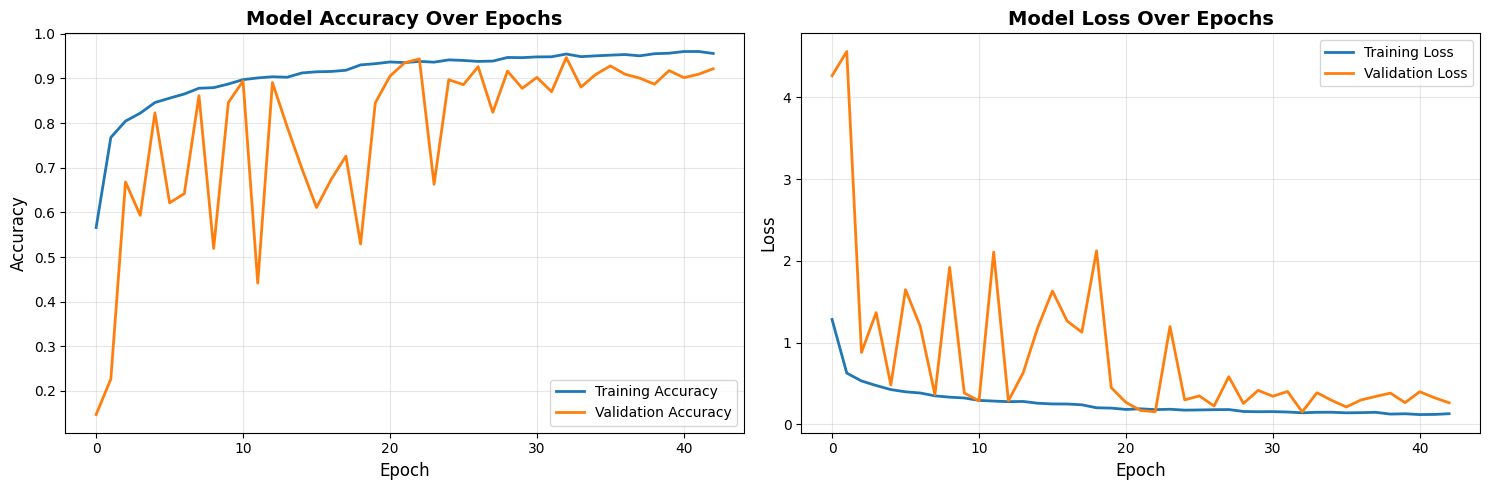

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_classes, target_names=class_names))

Test Loss: 0.1508
Test Accuracy: 0.9500
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

CLASSIFICATION REPORT
                       precision    recall  f1-score   support

             Basophil       0.83      0.99      0.90       244
           Eosinophil       0.99      1.00      1.00       624
         Erythroblast       0.99      0.95      0.97       311
Immature Granulocytes       0.88      0.89      0.89       579
           Lymphocyte       0.96      0.93      0.95       243
             Monocyte       0.98      0.77      0.86       284
           Neutrophil       0.96      0.99      0.97       666
             Platelet       1.00      1.00      1.00       470

             accuracy                           0.95      3421
            macro avg       0.95      0.94      0.94      3421
         weighted avg       0.95      0.95      0.95      3421



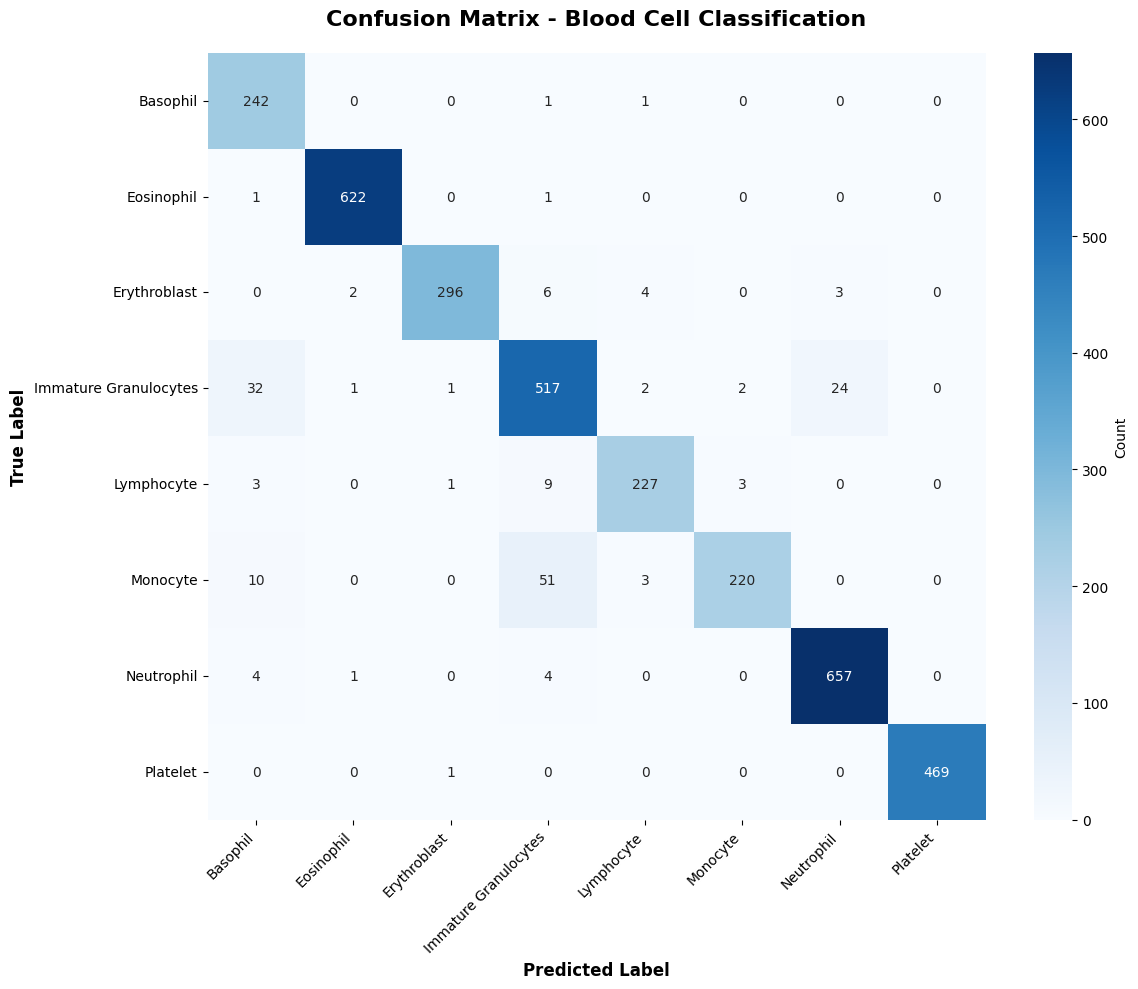

In [13]:
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Blood Cell Classification', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

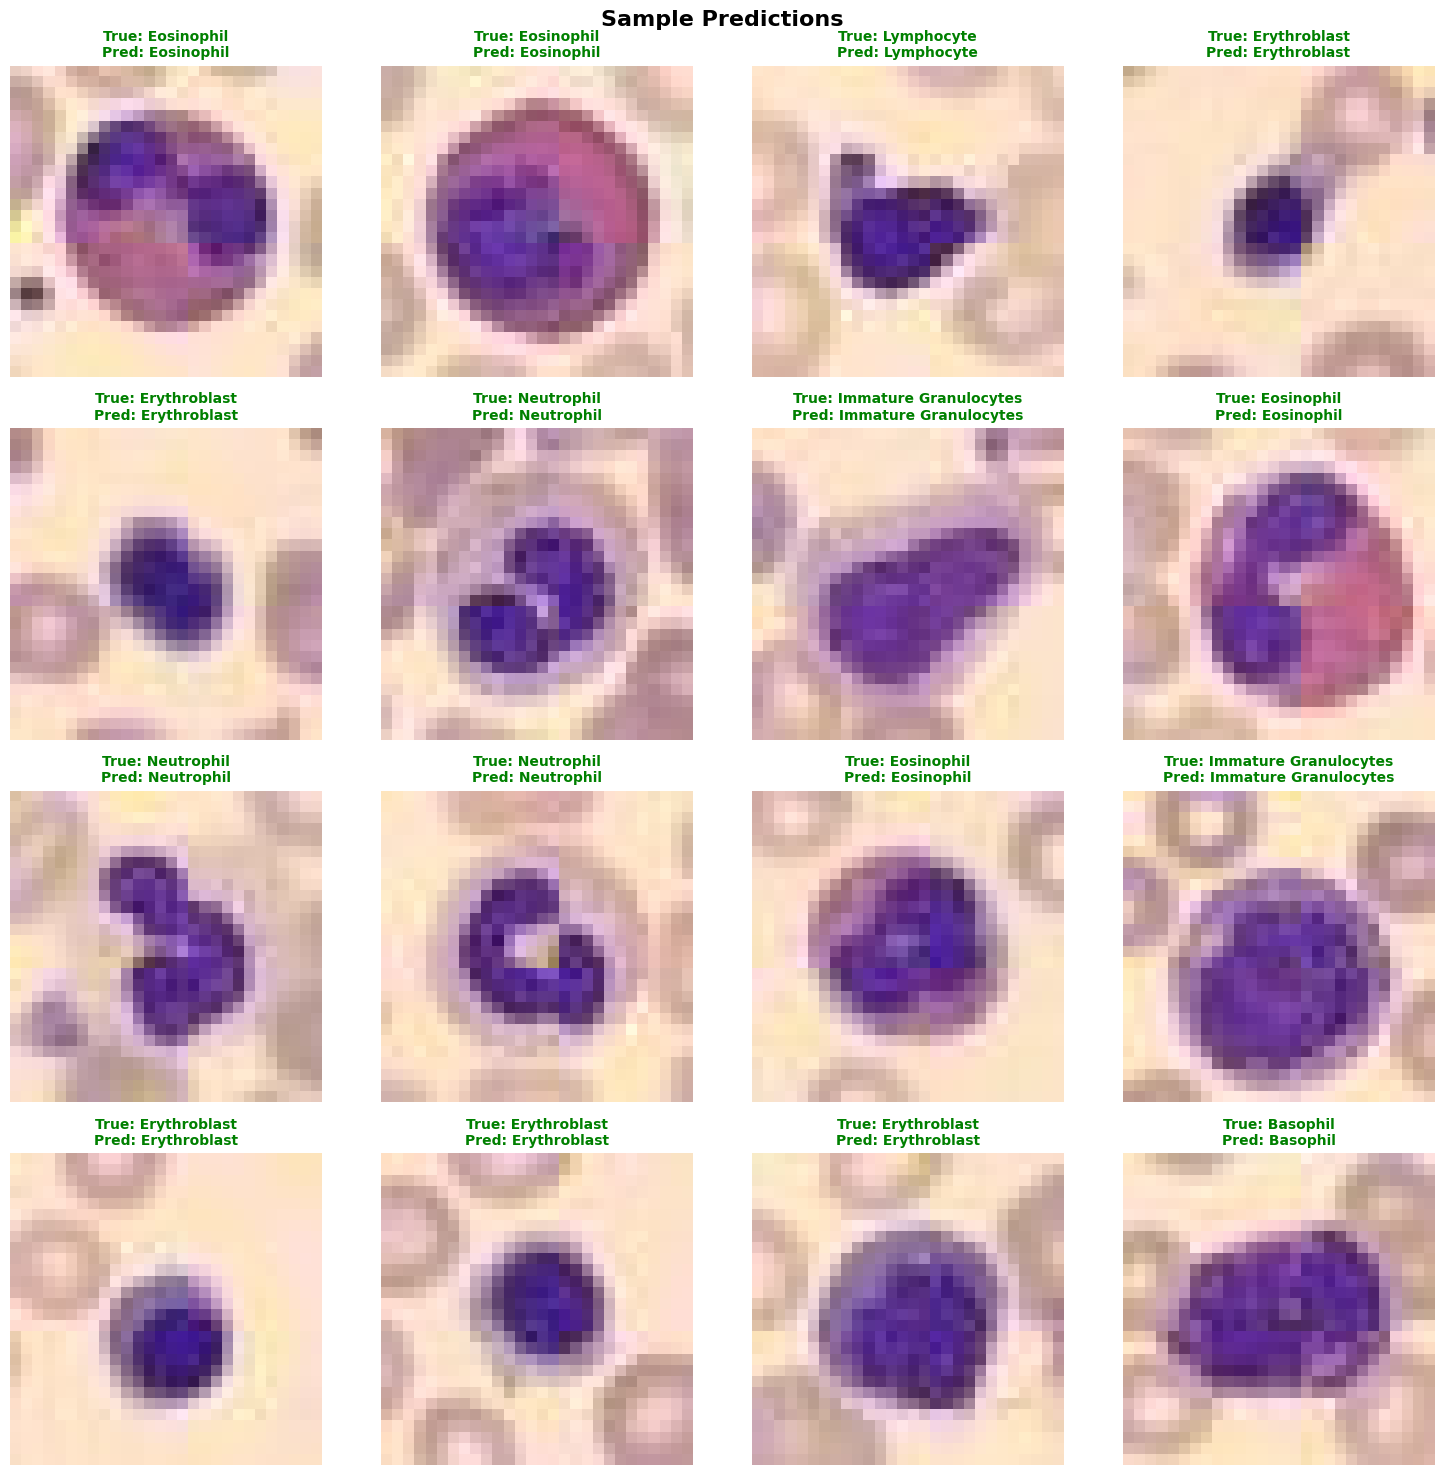

In [14]:
def plot_predictions(images, true_labels, pred_labels, class_names, n_samples=16):
    n_rows = 4
    n_cols = 4

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    fig.suptitle('Sample Predictions', fontsize=16, fontweight='bold')

    indices = np.random.choice(len(images), n_samples, replace=False)

    for idx, ax in enumerate(axes.flat):
        i = indices[idx]
        ax.imshow(images[i])

        true_label = class_names[true_labels[i]]
        pred_label = class_names[pred_labels[i]]

        color = 'green' if true_labels[i] == pred_labels[i] else 'red'

        ax.set_title(f'True: {true_label}\nPred: {pred_label}',
                    color=color, fontsize=10, fontweight='bold')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_predictions(x_test, y_test, y_pred_classes, class_names)

In [15]:
# Download the trained model
from google.colab import files

print("Downloading the trained model...")
files.download('best_blood_cell_model.keras')
print("✅ Model downloaded successfully!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Model downloaded successfully!
